In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, time
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual
from scipy.optimize import minimize, fmin_cg, approx_fprime
from numpy.linalg import norm
from numpy import Inf
from termcolor import colored, cprint

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import interp2d, SmoothBivariateSpline, RectBivariateSpline

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Level 2: calculating electron positions using `scipy.minimize` on a FEM obtained potential

In [5]:
save = False
data_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Potentials/V4 - Extended Trap"


In [ ]:
# Evaluate all files in the range
xeval=np.linspace(-4.5, 9.5, 501)
yeval = np.linspace(-3.0, 3.0, 151)

datafiles = [os.path.join(data_path, "Resonator.dsp"),
             os.path.join(data_path, "Trap.dsp"),
             os.path.join(data_path, "ResonatorGuard.dsp"),
             os.path.join(data_path, "CenterGuard.dsp"), 
             os.path.join(data_path, "TrapGuard.dsp")]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(12.,3.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter
    #interpolate_slow.plot_mesh(os.path.join(datafile))
    xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=(0, 1.0), 
                                                         plot_axes='xy', cmap=plt.cm.Spectral_r, plot_mesh=False)
    output.append({'name' : name, 'V' : np.array(Uinterp.T, dtype=np.float64),
                               'x' : np.array(xinterp.T, dtype=np.float64), 'y' : np.array(yinterp.T, dtype=np.float64)})
    
    plt.vlines(-1.5, np.min(yeval), np.max(yeval), linestyles="--", color="white")

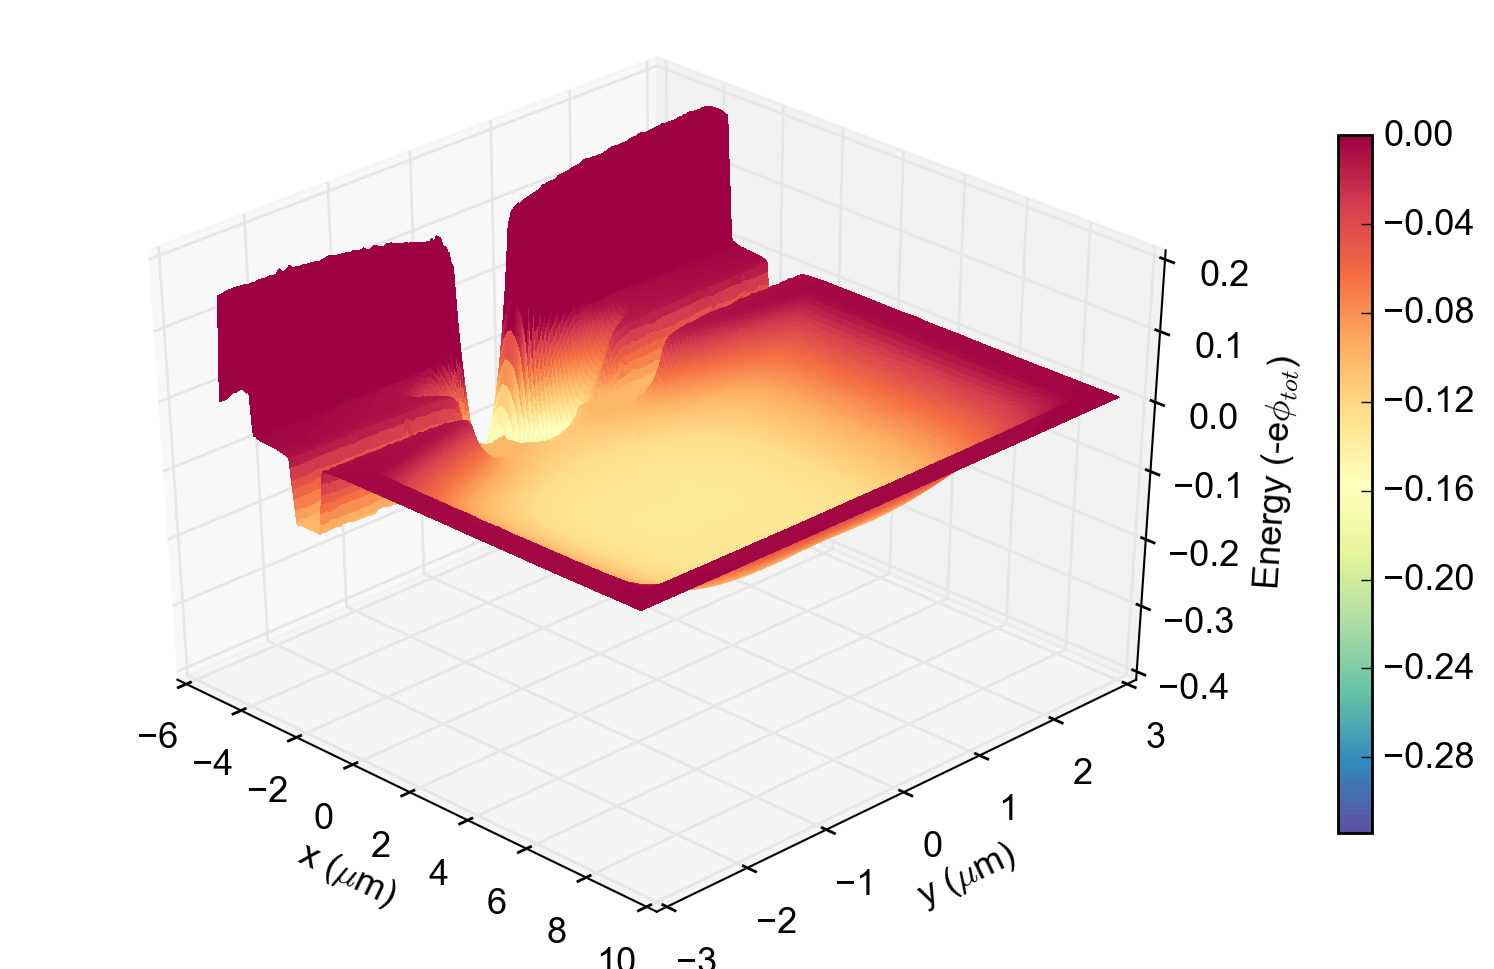

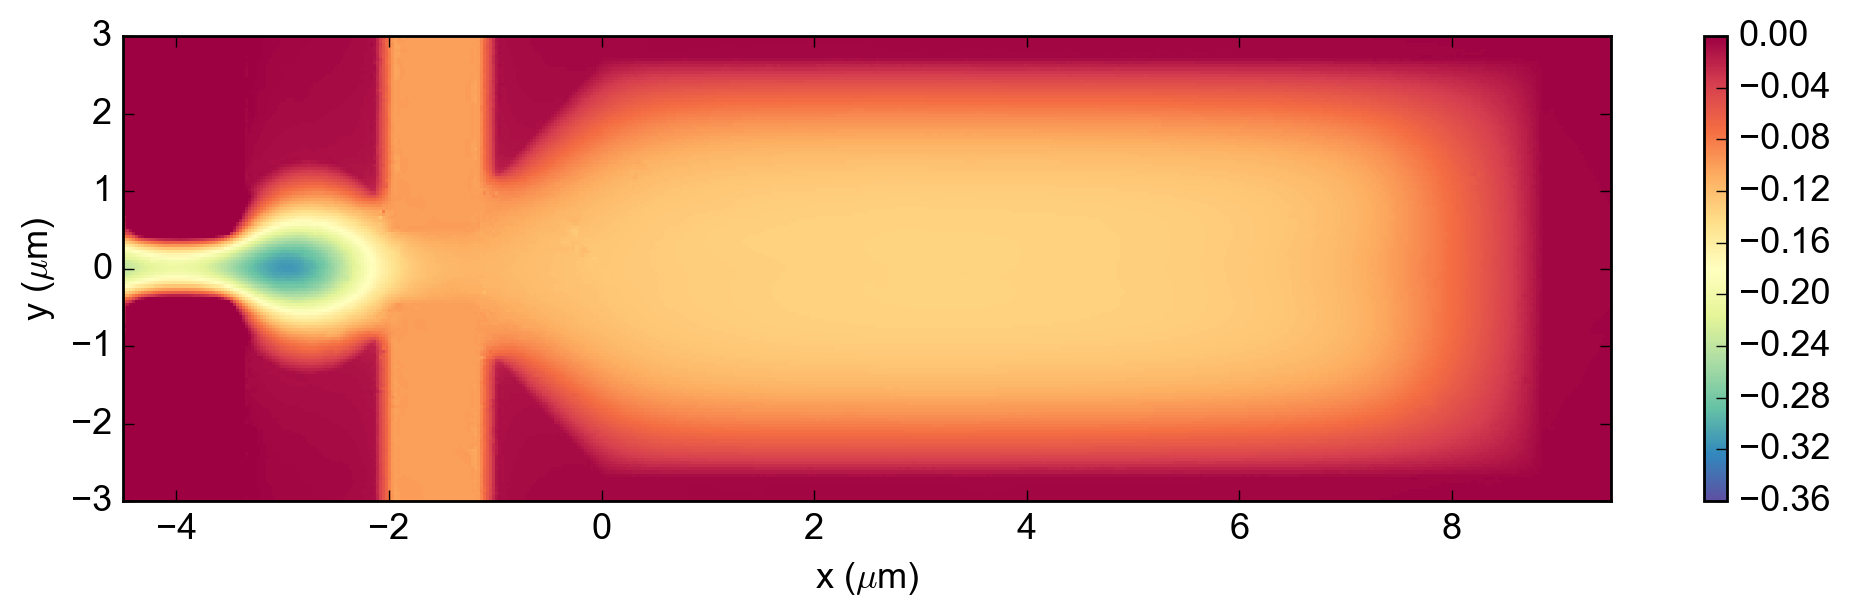

In [34]:
t = trap_analysis.TrapSolver()
c = trap_analysis.get_constants()

Vres = 0.20
Vtrap = 0.20
Vrg = 0.00
Vcg = 0.0
Vtg = -0.00

xeval, yeval, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
coefficients = np.array([Vres, Vtrap, Vrg, Vcg, Vtg])
combined_potential = t.get_combined_potential(cropped_potentials, coefficients)

Xm, Ym = np.meshgrid(xeval, yeval)

for view_angle in [-45]:
    fig = plt.figure(figsize=(10.,6.))
    common.configure_axes(13)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(Xm, Ym, -combined_potential, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                           linewidth=0, antialiased=False, vmax=0.0)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_zlabel("Energy (-e$\phi_{tot}$)")
    ax.view_init(elev=35., azim=view_angle)
    fig.colorbar(surf, shrink=0.75, aspect=20)  
    
fig = plt.figure(figsize=(12.,3.))
common.configure_axes(13)
plt.pcolormesh(Xm, Ym, -combined_potential, cmap=plt.cm.Spectral_r, vmax=0.0, vmin=-0.36)
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")
plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
plt.colorbar()

In [35]:
EP = anneal.ElectrostaticPotential(xeval*1E-6, yeval*1E-6, -combined_potential.T, 
                                   spline_order_x=3, spline_order_y=3, smoothing=0.01)

Verify that the above interpolation function represents the FEM data: 

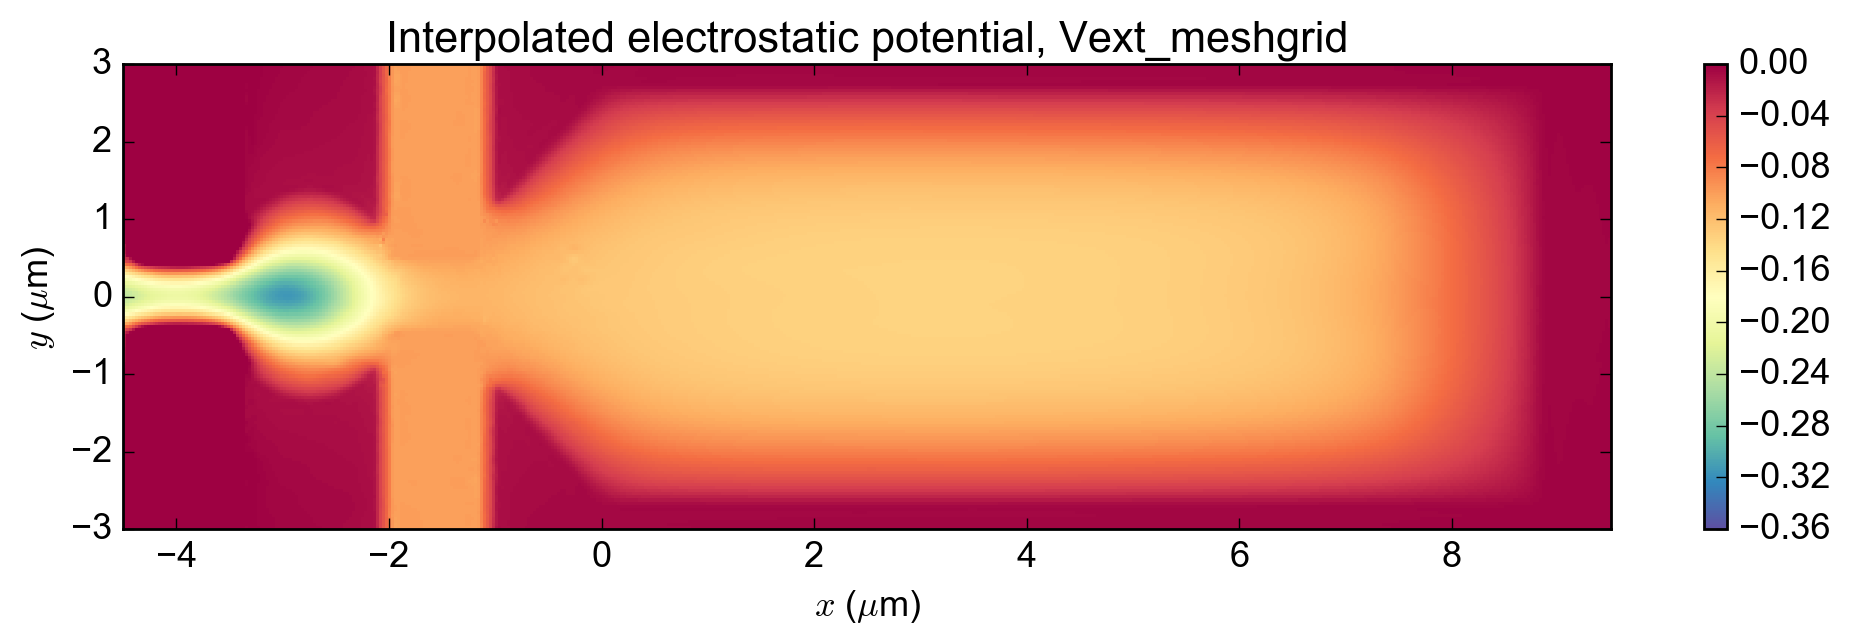

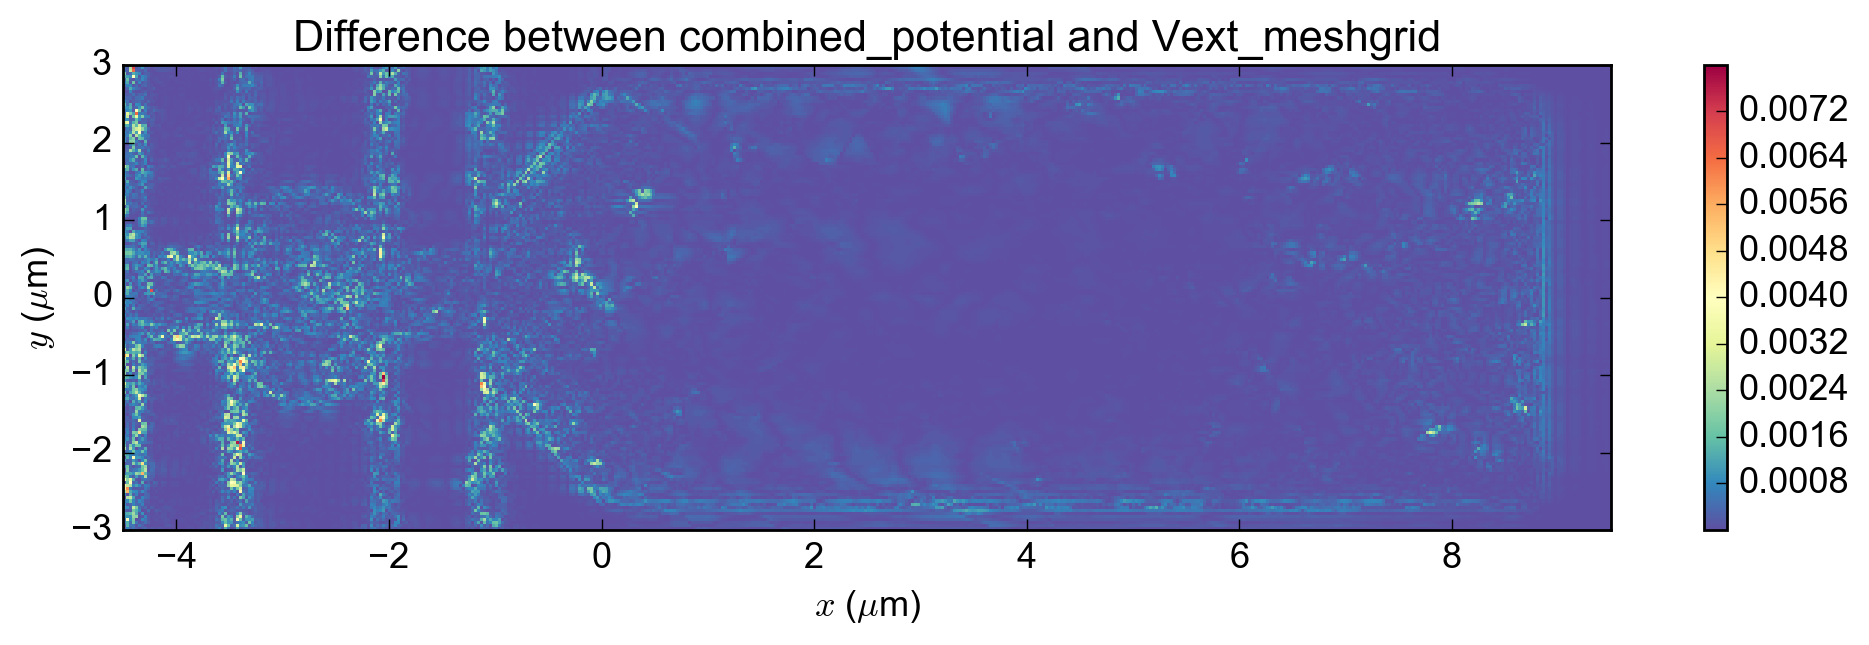

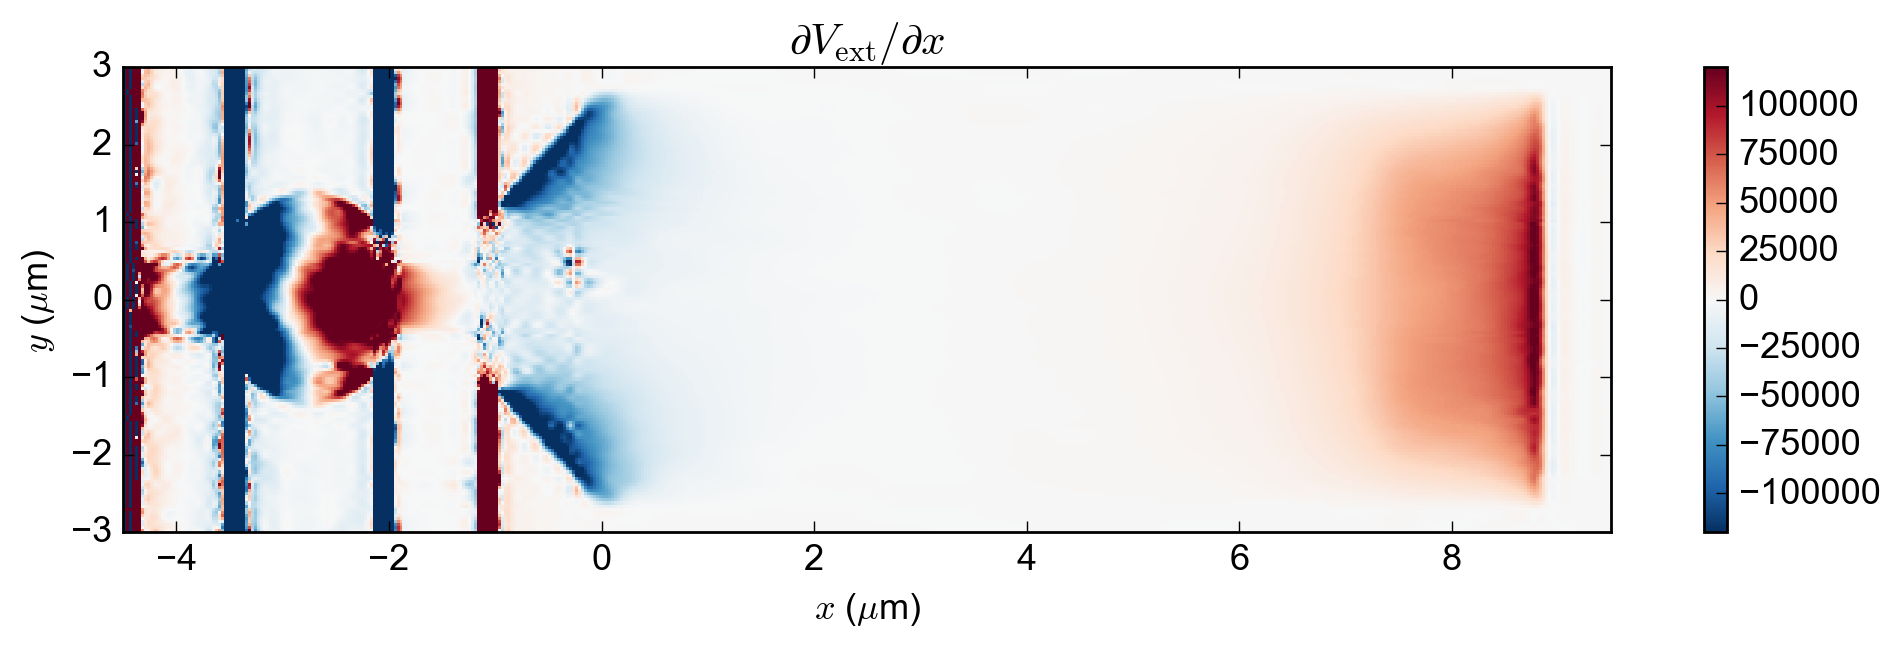

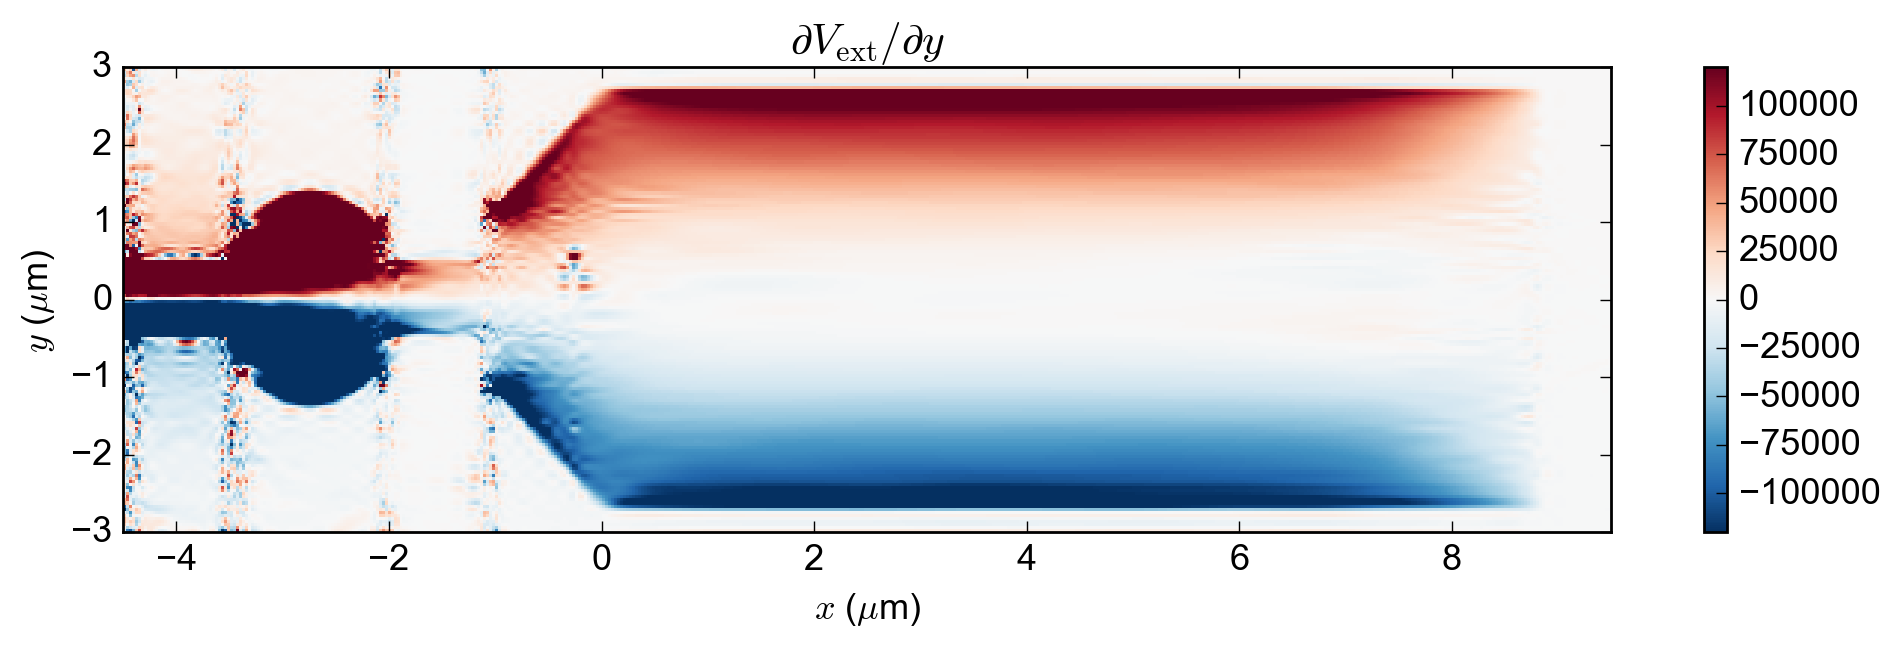

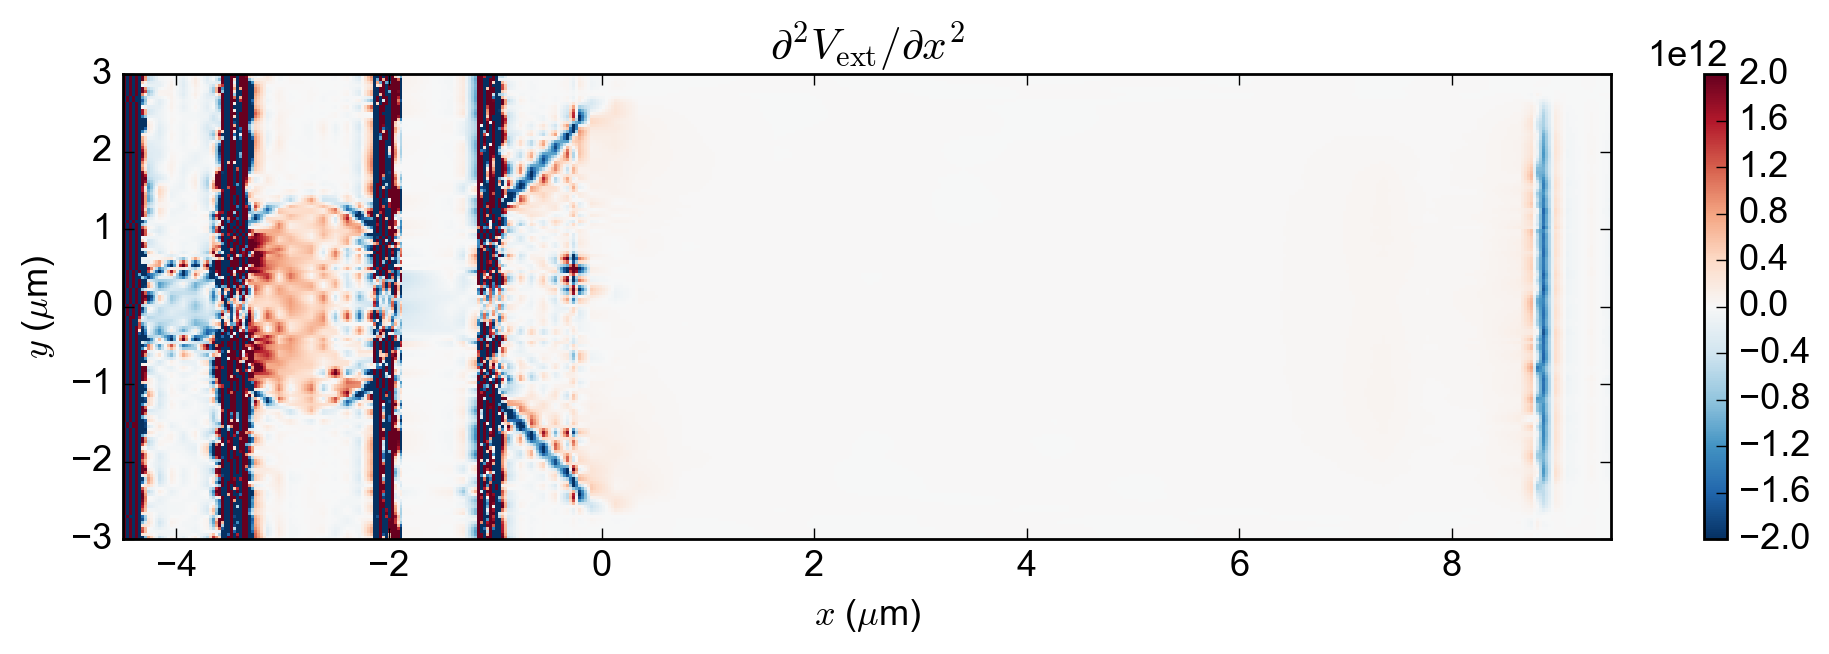

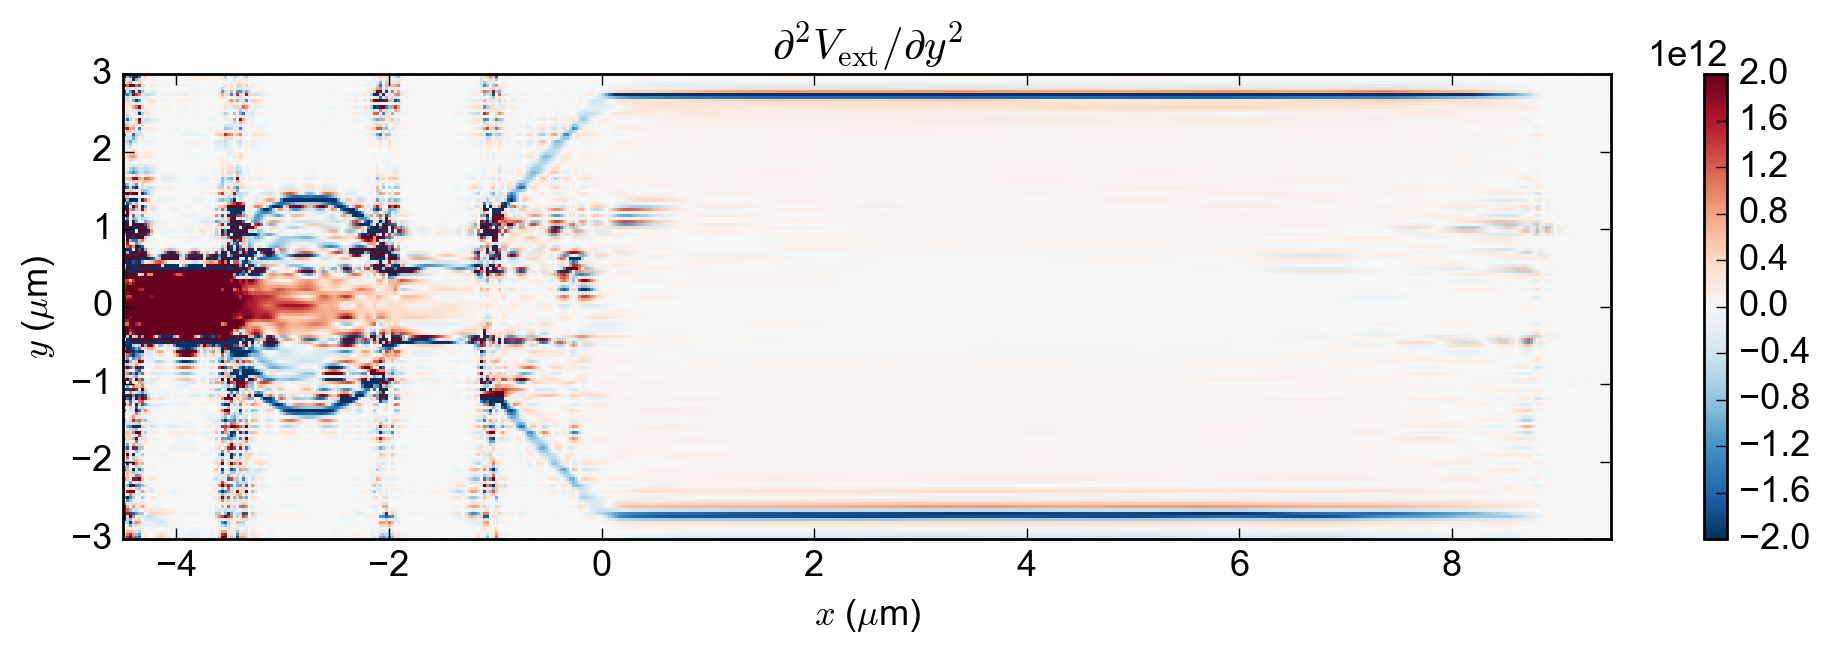

In [36]:
xtest = xeval*1E-6
ytest = yeval*1E-6
Xtest, Ytest = np.meshgrid(xtest, ytest)

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.V(Xtest, Ytest), vmax=0.00, vmin=-0.36, cmap=plt.cm.Spectral_r)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title("Interpolated electrostatic potential, Vext_meshgrid")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

if 1:
    plt.figure(figsize=(12.,3.))
    plt.pcolormesh(Xtest*1E6, Ytest*1E6, np.abs(EP.V(Xtest, Ytest)- (-combined_potential)), 
                   cmap=plt.cm.Spectral_r)
    plt.colorbar()
    plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
    plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
    plt.title(r"Difference between combined_potential and Vext_meshgrid")
    plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.dVdx(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-1E5*Vres/0.15, vmax=1E5*Vres/0.15)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial V_\mathrm{ext}/\partial x$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.dVdy(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-1E5*Vres/0.15, vmax=1E5*Vres/0.15)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial V_\mathrm{ext}/\partial y$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.ddVdx(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-2E12, vmax=2E12)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial^2 V_\mathrm{ext}/\partial x^2$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.ddVdy(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-2E12, vmax=2E12)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial^2 V_\mathrm{ext}/\partial y^2$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

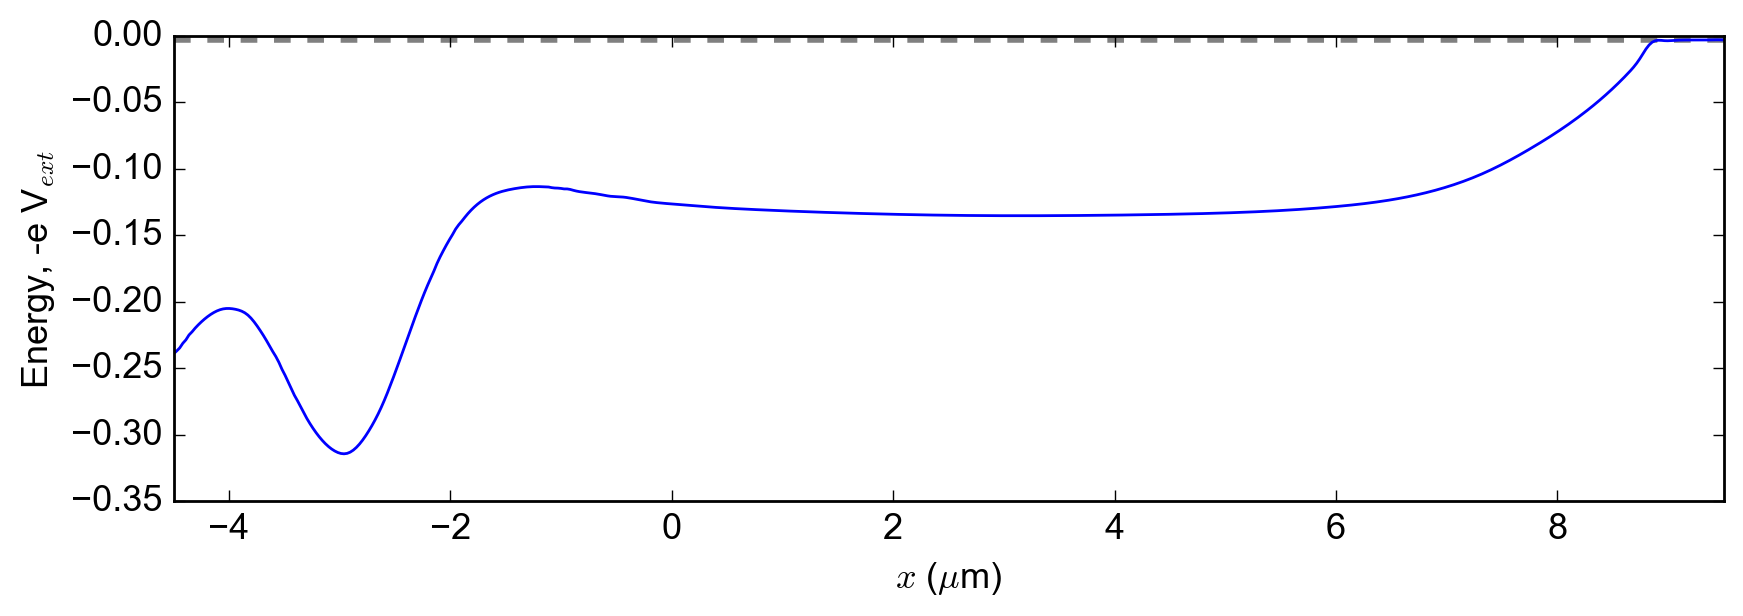

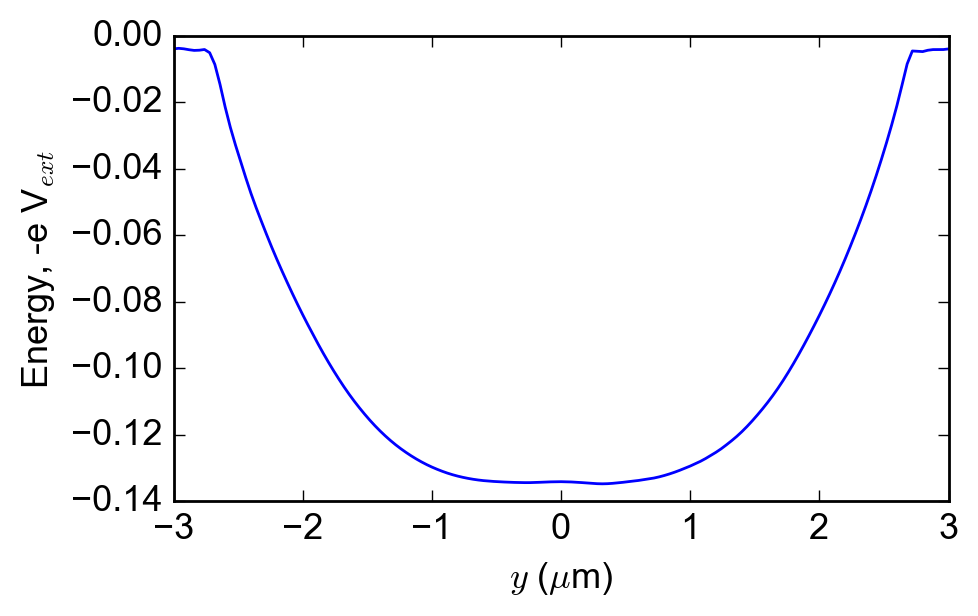

In [37]:
plt.figure(figsize=(10.,3.))
plt.plot(xeval, EP.V(xeval*1E-6, 0E-6))
plt.xlim(np.min(xeval), np.max(xeval))
plt.hlines(EP.V(xeval*1E-6, 0E-6)[-1], np.min(xeval), np.max(xeval), linestyles='--', color='gray', lw=2.0)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("Energy, -e V$_{ext}$")

plt.figure(figsize=(5.,3.))
plt.plot(yeval, EP.V(2E-6, yeval*1E-6))
plt.xlim(np.min(yeval), np.max(yeval))
plt.xlabel("$y$ ($\mu$m)")
plt.ylabel("Energy, -e V$_{ext}$")

In [17]:
%timeit EP.Velectrostatic(np.array([-2.7E-6, -2.7E-6, -2.7E-6]), np.array([-0.5E-6, 0, 0.5E-6]))

The slowest run took 6.54 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 13.8 µs per loop


Here are the parameters of the simulation. I arrange the electrons in a circle of radius `initial_radius`. The number of electrons can be tweaked by changing `N_electrons`

In [38]:
N_electrons = 50

if 1: 
    # Rectangle
    N_cols = 10
    N_rows = 5
    if N_cols*N_rows != N_electrons:
        raise ValueError("N_cols and N_rows are not compatible with N_electrons")
    else:
        separation = 200E-9
        x0 = 3.5E-6
        xs = np.linspace(x0, x0+N_cols*separation, N_cols)
        xinit = np.tile(np.array(xs), N_rows)
        ys = np.linspace(-(N_rows-1)/2.*separation, +(N_rows-1)/2.*separation, N_rows)
        yinit = np.repeat(ys, N_cols)
if 0: 
    # Semi-circle
    initial_radius = 2.0E-6
    xinit = xeval[-1]*1E-6 + initial_radius*np.cos(2*np.pi * np.arange(0, N_electrons)/(2*N_electrons) + np.pi/2.)
    yinit = initial_radius*np.sin(2*np.pi * np.arange(0, N_electrons)/(2*N_electrons) + np.pi/2.)
if 0: 
    # Single line parallel to y
    x0 = 1E-6
    initial_span = 3E-6   
    xinit = x0 * np.ones(N_electrons)
    yinit = np.linspace(-initial_span/2., initial_span/2., N_electrons)

electron_initial_positions = anneal.xy2r(xinit, yinit)

# Checks and timing

We can now evaluate the total potential at the initial positions of the electrons. This gives us an idea of the number we see when we start the minimization procedure. Note that the unit is in eV

In [ ]:
EP.Vtotal(electron_initial_positions)

This number will always go down when we start the minimization (per definition). Let's find out how fast the function call is for the total energy:

In [ ]:
%timeit EP.Vtotal(electron_initial_positions)

And let's find out the value of the $L^\infty$-norm of the gradient before beginning the minimization, and how fast it is: 

In [ ]:
print(np.amax(np.abs(EP.grad_total(electron_initial_positions))))
%timeit EP.grad_total(electron_initial_positions)

# A single configuration of electrodes

Here is the actual minimization. First we set the matplotlib to Agg to suppress any plots that may come up. For callback we can choose `monitor_convergence` for simply printing the total energy every `N` iterations. We can also choose `save_pictures` to create a movie afterwards. The latter also prints the function value every `N` iterations. 

In [39]:
def thermal_kick_x(x, y, T):
    kB = 1.38E-23
    qe = 1.602E-19
    ktrapx = np.abs(qe*EP.ddVdx(xi=x, yi=y))
    return np.sqrt(2*kB*T/ktrapx)

def thermal_kick_y(x, y, T):
    kB = 1.38E-23
    qe = 1.602E-19
    ktrapy = np.abs(qe*EP.ddVdy(xi=x, yi=y))
    return np.sqrt(2*kB*T/ktrapy)

#print(np.mean(thermal_kick_x(x, y, 2.0)), np.mean(thermal_kick_y(x, y, 2.0)))

Optimization terminated successfully.
         Current function value: -5.748530
         Iterations: 722
         Function evaluations: 1216
         Gradient evaluations: 1216
Perturbing final state at T = 4.00e+00 K
Perturbing final state at T = 4.00e+00 K
Perturbing final state at T = 4.00e+00 K
Perturbing final state at T = 4.00e+00 K
Perturbing final state at T = 4.00e+00 K
Perturbing final state at T = 4.00e+00 K
Perturbing final state at T = 4.00e+00 K
Perturbing final state at T = 4.00e+00 K
Perturbing final state at T = 4.00e+00 K
Perturbing final state at T = 4.00e+00 K
After perturbation, minimum function value obtained: -5.74853542 eV with gradient 0.0737 eV/m


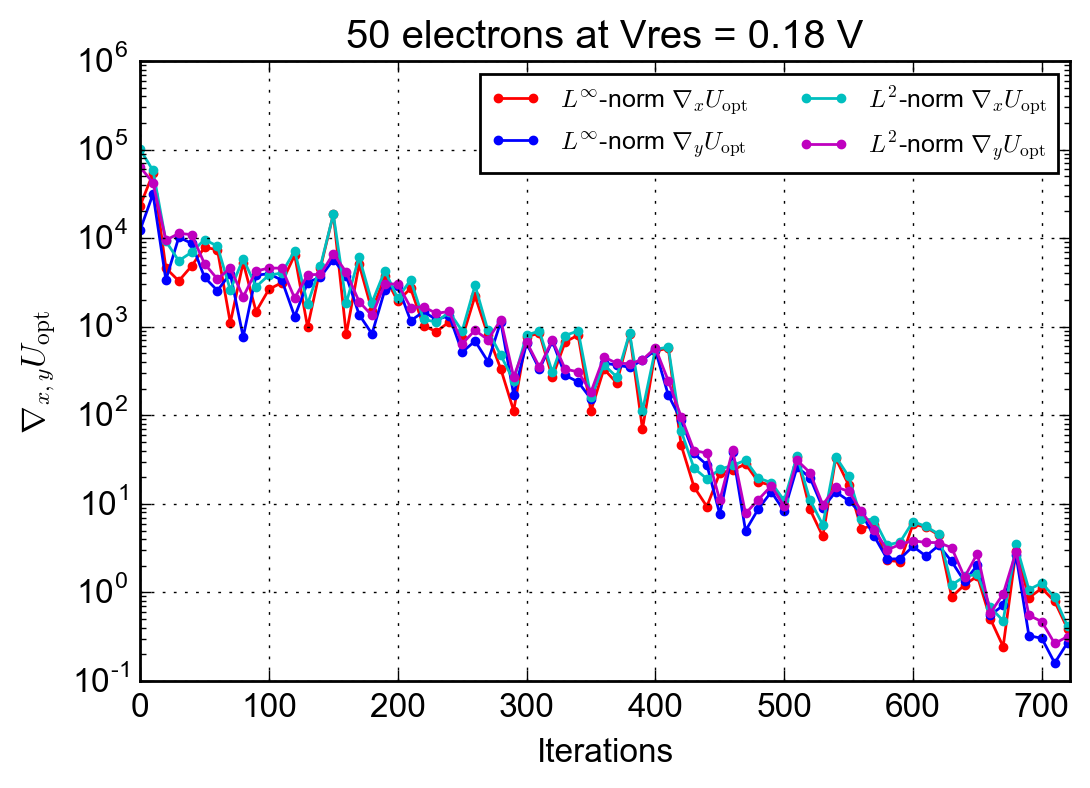

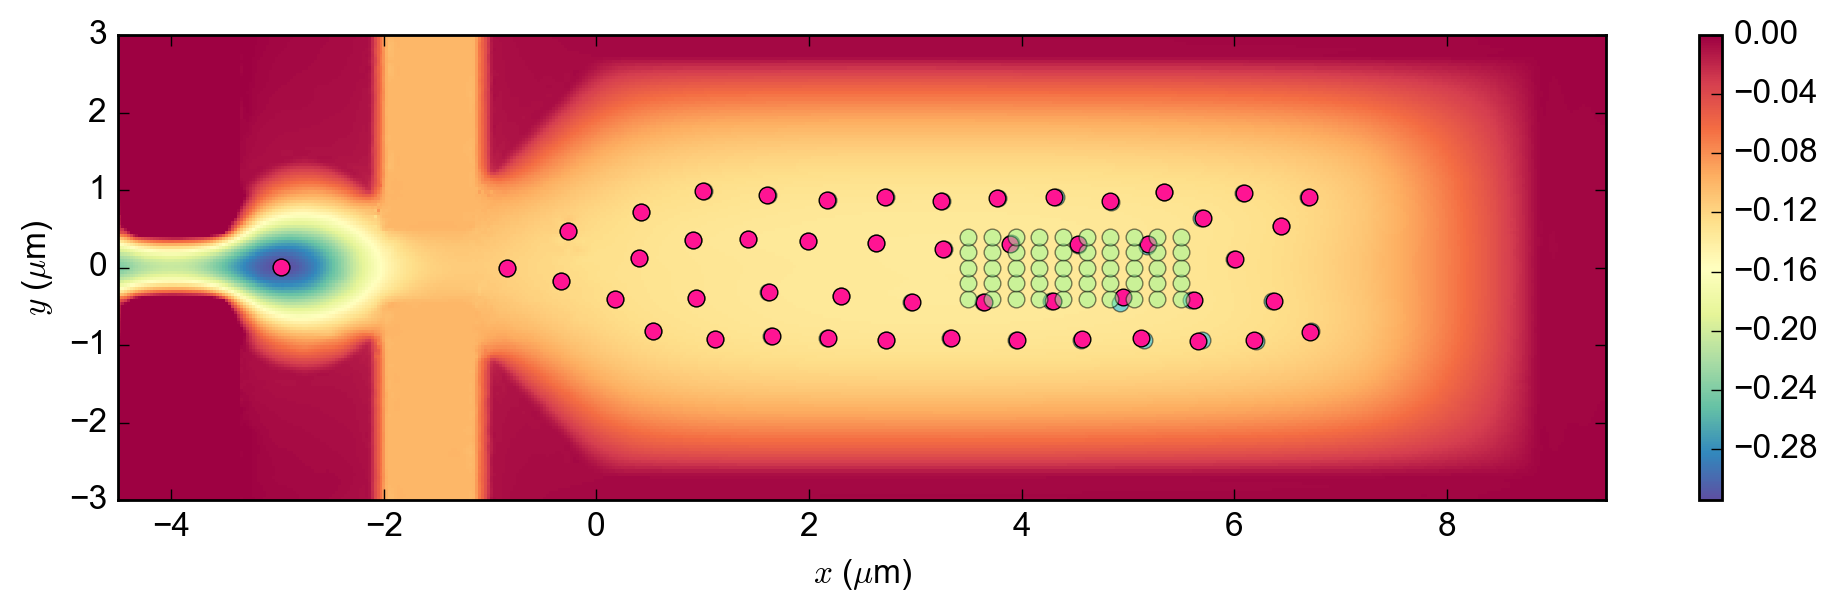

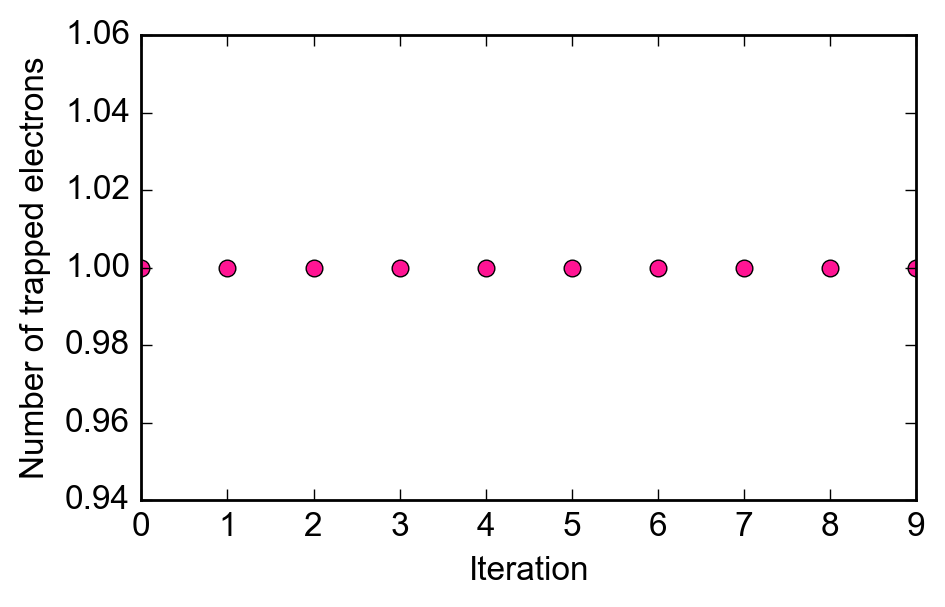

In [41]:
epsilon = 1e-12
use_gradient = True
annealing_steps = [4.0]*10
simulation_name = "50_electrons_anneal_4K"
save_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Perturbing"
sub_dir = time.strftime("%H%M%S_{}".format(simulation_name))
save = False
num_trapped_electrons = list()

if save: 
    os.mkdir(os.path.join(save_path, sub_dir))
    time.sleep(1)
    os.mkdir(os.path.join(save_path, sub_dir, "Figures"))
    os.mkdir(os.path.join(save_path, sub_dir, "Movie"))
    os.mkdir(os.path.join(save_path, sub_dir, "Data"))

conv_mon_save_path = os.path.join(save_path, sub_dir, "Figures")

ConvMon = anneal.ConvergenceMonitor(Uopt=EP.Vtotal, grad_Uopt=EP.grad_total, N=10, 
                                    Uext=EP.V, 
                                    xext=xeval*1E-6, yext=yeval*1E-6, verbose=False, eps=epsilon, 
                                    save_path=conv_mon_save_path)

if use_gradient: 
    jac=EP.grad_total
else:
    jac = None

res = minimize(EP.Vtotal, electron_initial_positions, method='CG', 
               jac=jac, 
               options={'disp': True, 'gtol' : 1E-1}, 
               callback=ConvMon.monitor_convergence)

x, y = anneal.r2xy(res['x'])
final_func_val = res['fun']
n_iterations = res['nit']

%matplotlib inline
if len(np.shape(ConvMon.jac))>1:
    figgy = plt.figure(figsize=(6,4))
    common.configure_axes(12)
    # LInf-norm
    plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,::2]), axis=1), 
             '.-r', label=r'$L^\infty$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,1::2]), axis=1), 
             '.-b', label=r'$L^\infty$-norm $\nabla_y U_\mathrm{opt}$')
    # L2-norm
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,::2])**2.0, axis=1)**(1/2.), 
             '.-c', label=r'$L^2$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,1::2])**2.0, axis=1)**(1/2.), 
             '.-m', label=r'$L^2$-norm $\nabla_y U_\mathrm{opt}$')

    plt.title("%d electrons at Vres = %.2f V"%(N_electrons, Vres))
        
    plt.xlabel("Iterations")
    plt.ylabel(r"$\nabla_{x,y} U_\mathrm{opt}$")
    plt.yscale('log')
    plt.xlim(0, res['nit'])
    plt.grid()
    plt.legend(loc=0, ncol=2, prop = {'size' : 9})

# Perturb the system to see if we got the global minimum.
perturbed_positions = np.zeros(len(electron_initial_positions))
x_a, y_a = anneal.r2xy(res['x'])    

# Restart convergence monitor
ConvMon.call_counter = 0
ConvMon.figsize = (8.,2.)

for A, T in enumerate(annealing_steps):    
    cprint("Perturbing final state at T = %.2e K"%(T), 'blue')
    
    perturbed_x = x_a + thermal_kick_x(x_a, y_a, T) * np.random.rand(len(x))
    perturbed_y = y_a + thermal_kick_y(x_a, y_a, T) * np.random.rand(len(y))

    perturbed_positions[::2] = perturbed_x
    perturbed_positions[1::2] = perturbed_y

    res = minimize(EP.Vtotal, perturbed_positions, method='CG', 
                   jac=jac, 
                   options={'disp': False, 'gtol' : 1E-1}, 
                   callback=ConvMon.monitor_convergence)
    
    PP = anneal.PostProcess(save_path=os.path.join(save_path, sub_dir, "Figures"))
    num_trapped_electrons.append(PP.get_trapped_electrons(res['x']))

    if res['fun'] < final_func_val and res['status'] == 0:
        final_func_val = res['fun']
        x_pre_anneal, y_pre_anneal = anneal.r2xy(res['x'])
        jac_pre_anneal = np.amax(np.abs(res['jac']))

    elif res['fun'] < final_func_val and res['status'] > 0:
        cprint("There is a lower energy state, but the minimizer did not converge", "red")

        figgy = plt.figure(figsize=(6,4))
        common.configure_axes(12)
        # LInf-norm
        plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,::2]), axis=1), 
                 '.-r', label=r'$L^\infty$-norm $\nabla_x U_\mathrm{opt}$')
        plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,1::2]), axis=1), 
                 '.-b', label=r'$L^\infty$-norm $\nabla_y U_\mathrm{opt}$')
        # L2-norm
        plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,::2])**2.0, axis=1)**(1/2.), 
                 '.-c', label=r'$L^2$-norm $\nabla_x U_\mathrm{opt}$')
        plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,1::2])**2.0, axis=1)**(1/2.), 
                 '.-m', label=r'$L^2$-norm $\nabla_y U_\mathrm{opt}$')

        plt.title("%d electrons at Vres = %.2f V"%(N_electrons, Vres))

        plt.xlabel("Iterations")
        plt.ylabel(r"$\nabla_{x,y} U_\mathrm{opt}$")
        plt.yscale('log')
        plt.xlim(0, res['nit'])
        plt.grid()
        plt.legend(loc=0, ncol=2, prop = {'size' : 9})

    elif res['fun'] >= final_func_val and res['status'] > 0:
        cprint("Minimizer did not converge, but this is not the lowest energy state", "magenta")

if save: 
    # Create a movie
    ConvMon.create_movie(fps=10, 
                         filenames_in="%05d.png", 
                         filename_out="%d_electrons_4K_anneal.mp4"%(N_electrons))

    # Move the file from the Figures folder to the Movie folder
    os.rename(os.path.join(save_path, sub_dir, 
                           "Figures/%d_electrons_4K_anneal.mp4"%(N_electrons)),
              os.path.join(save_path, sub_dir, 
                           "Movie/%d_electrons_4K_anneal.mp4"%(N_electrons)))

cprint("After perturbation, minimum function value obtained: %.8f eV with gradient %.4f eV/m"\
       %(final_func_val, jac_pre_anneal), "green")
            
x_a, y_a = x_pre_anneal, y_pre_anneal
    
# Compare state before and after annealing: 
Xeval, Yeval = np.meshgrid(xeval, yeval)
figgy = plt.figure(figsize=(12,3))
common.configure_axes(12)
plt.pcolormesh(xeval, yeval, EP.V(Xeval*1E-6, Yeval*1E-6), cmap=plt.cm.Spectral_r, vmax=0.0)
plt.plot(x*1E6, y*1E6, 'o', color='deepskyblue', alpha=0.5)
plt.plot(x_a*1E6, y_a*1E6, 'o', color='deeppink')
plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

# Plot number of trapped electrons
plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(num_trapped_electrons, 'o', color='deeppink')
plt.xlabel("Iteration")
plt.ylabel("Number of trapped electrons")

In [ ]:
if 0:
    ConvMon.create_movie(fps=10)

In [ ]:
#Xinit, Yinit = anneal.map_into_domain(xinit, yinit)
#X, Y = anneal.map_into_domain(x, y)
Xeval, Yeval = np.meshgrid(xeval, yeval)

figgy = plt.figure(figsize=(12,3))
common.configure_axes(12)
plt.pcolormesh(xeval, yeval, EP.V(Xeval*1E-6, Yeval*1E-6), cmap=plt.cm.Spectral_r, vmax=0.0)
#plt.plot(x*1E6, y*1E6, 'o', color='deepskyblue')
plt.plot(res['x'][::2]*1E6, res['x'][1::2]*1E6, 'o', color='deeppink')
plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)

plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

if save: 
    common.save_figure(figgy, save_path=save_path)

In [ ]:
#Calculate the electron density
xi, yi = anneal.r2xy(res['x'])
Xi, Yi = np.meshgrid(xi, yi)
Xj, Yj = Xi.T, Yi.T

Rij = np.sqrt((Xi-Xj)**2 + (Yi-Yj)**2)
np.fill_diagonal(Rij, 1E10)

nearest_neighbors = np.min(Rij, axis=1)
ns = 1/(np.mean(nearest_neighbors))**2 
print("The electron density in the figure above is %.3e m^-2"%ns)

In [ ]:
plt.figure(figsize=(12.,12.))

for n in range(20,32,1):
    plt.subplot(4,3,(n+1)-20)
    plt.title("Electron #%d"%(n+1))
    plt.plot(ConvMon.iter, ConvMon.approx_fprime[:,2*n], 'r', 
             alpha=0.2, lw=4.0, label=r'$\nabla_x$ appr')
    plt.plot(ConvMon.iter, ConvMon.jac[:,2*n], 'k', 
             label=r'$\nabla_x$ analytic')
    plt.plot(ConvMon.iter, ConvMon.jac[:,2*n+1], 'b', 
             alpha=0.2, lw=4.0, label=r'$\nabla_y$ appr')
    plt.plot(ConvMon.iter, ConvMon.jac[:,2*n+1], 'k', 
             label=r'$\nabla_y$ analytic')
    #plt.plot(grady_Vext(res['x'][::2], res['x'][1::2])/gc['e'])
    if not n%3:
        plt.ylabel(r"$\nabla U_\mathrm{opt}$")
    if n>=9:
        plt.xlabel('Iterations')
    plt.xlim(0, ConvMon.iter[-1])
    
    plt.legend(loc=0, prop={'size':9})

In [ ]:
%matplotlib inline

#Xinit, Yinit = map_into_domain(xinit, yinit)
X, Y = anneal.map_into_domain(x, y)
Xeval, Yeval = np.meshgrid(xeval, yeval)

figgy = plt.figure(figsize=(12,3))
common.configure_axes(12)
plt.pcolormesh(xeval, yeval, EP.V(Xeval*1E-6, Yeval*1E-6), cmap=plt.cm.Spectral_r, vmax=0.0)
plt.plot(x*1E6, y*1E6, 'o', color='deepskyblue')
#plt.plot(X*1E6, Y*1E6, 'o', color='deepskyblue')
plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
#plt.plot(Xinit*1E6, Yinit*1E6, 'o', color='palegreen', alpha=0.5)
for k, dummy in enumerate(X):
    plt.text(x[k]*1E6, y[k]*1E6 + 0.1, str(k+1), fontdict={'color' : 'black', 'size' : 10}, va='bottom', ha='center')

plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
#plt.axes().set_aspect('equal', 'datalim')
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

if save:
    common.save_figure(figgy, save_path=save_path)